In [1]:
from collections import Counter
import os

from sklearn.model_selection import train_test_split
from monai.data import decollate_batch, DataLoader
from sklearn.metrics import classification_report
from monai.apps import download_and_extract
from monai.networks.nets import DenseNet121
from monai.utils import set_determinism
from monai.metrics import ROCAUCMetric
from monai.config import print_config
from imutils.paths import list_images
import matplotlib.pyplot as plt
from monai import transforms
import numpy as np
import torch
import PIL

print_config()

/opt/conda/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/ml/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


MONAI version: 1.2.0
Numpy version: 1.25.2
Pytorch version: 1.13.1.post200
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /opt/conda/envs/ml/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.12
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.21.0
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.1
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.32.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://doc

In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-4])
DATA_PATH = f'{ROOT_PATH}/Dataset/MONAI/mednist'

os.makedirs(DATA_PATH, exist_ok = True)

## **1.MEDNIST 데이터 셋 확인해 보기**
### 1-1. MEDNIST 데이터 셋 다운로드

In [3]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(DATA_PATH, 'MedNIST.tar.gz')
download_and_extract(resource, compressed_file, DATA_PATH, md5)

set_determinism(seed = 0)

2023-08-24 06:51:01,443 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-08-24 06:51:01,444 - INFO - File exists: /home/jovyan/dove/utils/TIL/Dataset/MONAI/mednist/MedNIST.tar.gz, skipped downloading.
2023-08-24 06:51:01,444 - INFO - Non-empty folder exists in /home/jovyan/dove/utils/TIL/Dataset/MONAI/mednist/MedNIST, skipped extracting.


### 1-2. MEDNIST 데이터 특징 살펴보기

In [4]:
image_paths   = sorted(list_images(f'{DATA_PATH}/MedNIST'))
dataset_names = [x.split(SEP)[-2] for x in image_paths]
w, h          = PIL.Image.open(image_paths[0]).size

print(f'        레이블 이름   : {set(dataset_names)}')
print(f'데이터 셋 이미지 크기   : {w} x {h}')
print(f'전체 데이터 셋 이미지 수 : {len(image_paths)}')
print(list(Counter(dataset_names).values()))

        레이블 이름   : {'BreastMRI', 'ChestCT', 'Hand', 'AbdomenCT', 'HeadCT', 'CXR'}
데이터 셋 이미지 크기   : 64 x 64
전체 데이터 셋 이미지 수 : 58954
[10000, 8954, 10000, 10000, 10000, 10000]


In [5]:
lb2idx = {lb  : idx for idx, lb  in enumerate(set(dataset_names))}
idx2lb = {idx : lb  for lb , idx in lb2idx.items()}

### 1-3. 샘플 데이터 확인해 보기

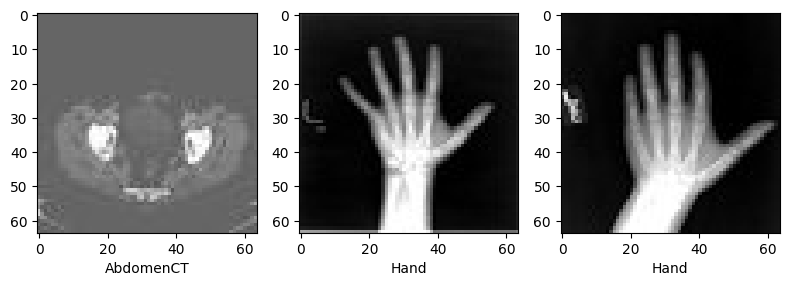

In [6]:
_, axes  = plt.subplots(1, 3, figsize = (8, 8))
rand_idx = np.random.randint(len(image_paths), size = 3)

for idx, (k, ax) in enumerate(zip(rand_idx, axes)):
    
        im  = PIL.Image.open(image_paths[k])
        arr = np.array(im)
        
        xlabel = image_paths[k].split(SEP)[-2]
        ax.set_xlabel(xlabel)
        ax.imshow(arr, cmap = 'gray', vmin = 0, vmax = 255)
        
plt.tight_layout()
plt.show()

### 1-4. MONAI 데이터 셋 구성모듈 확인
#### 1-4.1 transforms

In [7]:
labels = [lb2idx[x.split(SEP)[-2]] for x in image_paths]
train_x, valid_x, train_y, valid_y = train_test_split(image_paths, labels,
                                                      stratify = labels, test_size = 0.1)

train_x, test_x, train_y, test_y = train_test_split(train_x, train_y,
                                                      stratify = train_y, test_size = 1/9)

print(f'train dataset 크기 : {len(train_x)}')
print(f'valid dataset 크기 : {len(valid_x)}')
print(f'test  dataset 크기 : {len(test_x)}')

train dataset 크기 : 47162
valid dataset 크기 : 5896
test  dataset 크기 : 5896


In [8]:
train_transforms = transforms.Compose([
                transforms.LoadImage(image_only = True),
                transforms.EnsureChannelFirst()        ,
                transforms.ScaleIntensity()            ,
                transforms.RandRotate(range_x = np.pi / 12, prob = 0.5, keep_size = True),
                transforms.RandFlip(spatial_axis = 0, prob = 0.5),
                transforms.RandZoom(min_zoom = 0.9, max_zoom = 1.1, prob = 0.5)
            ])

valid_transforms = transforms.Compose([
                transforms.LoadImage(image_only = True),
                transforms.EnsureChannelFirst()
            ])

y_pred_trans = transforms.Compose([
                    transforms.Activations(softmax = True)
                ])
y_trans      = transforms.Compose([
                    transforms.AsDiscrete(to_onehot = len(dataset_names))
                ])

#### 1-4.2. Dataset

In [9]:
class MedNISTDataset(torch.utils.data.Dataset):
    
    def __init__(self, images, labels, transforms):
        
        self.images     = images
        self.labels     = labels
        self.transforms = transforms
        
    
    def __len__(self):
        return len(self.images)
    
    
    def __getitem__(self, idx):
        
        images = self.transforms(self.images[idx])
        return images, self.labels[idx]

In [10]:
train_dataset = MedNISTDataset(train_x, train_y, train_transforms)
valid_dataset = MedNISTDataset(valid_x, valid_y, valid_transforms)

train_loader  = DataLoader(train_dataset, batch_size = 256, shuffle =  True)
valid_loader  = DataLoader(valid_dataset, batch_size = 256, shuffle = False)

(-0.5, 63.5, 63.5, -0.5)

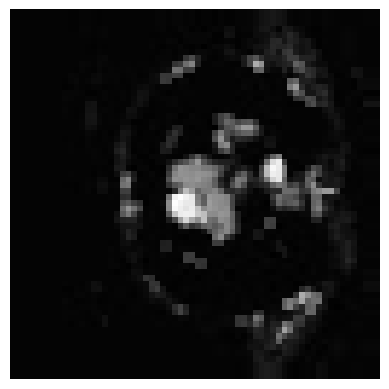

In [11]:
sample       = next(iter(train_loader))
image, label = sample
image, label = image[0], label[0]

plt.imshow(np.transpose(image, (1, 2, 0)), cmap = 'gray')
plt.axis(False)

### 1-5. pre-trained 네트워크, 최적화 함수 정의
- Monai에서 사전 학습된 DenseNet 네트워크는 2D / 3D 분류 모델에 사용될 수 있다.

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = DenseNet121(spatial_dims = 2, in_channels = 1, 
                     out_channels = len(dataset_names)).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs    = 10
val_interval  = 1
log_step      = 50
auc_metric    = ROCAUCMetric()

/opt/conda/envs/ml/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


#### 1-5.1. 모델 학습

In [13]:
best_metric       = -1
best_metric_epoch = -1
losses, metrics   = [], []
os.makedirs('models', exist_ok = True)

for epoch in range(1, max_epochs + 1):
    
    print(f'[{epoch}/{max_epochs}]')
    model.train()
    loss, step = 0, 0
    
    for batch in train_loader:
        
        images, labels = batch
        images         = images.to(device)
        labels         = labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss_   = loss_function(outputs, labels)
        
        loss_.backward()
        optimizer.step()
        
        loss += loss_.item()
        step += 1
        
        epoch_len = len(train_dataset) // train_loader.batch_size
        if step % log_step == 0:
            print(f'[{step} / {epoch_len}] train_loss : {loss_.item():.3f}')
        
    
    loss /= step
    losses.append(loss)
    print(f'[{epoch} / {max_epochs}] avg loss : {loss:.3f}')

    
    if (epoch + 1) % val_interval == 0:
        
        model.eval()
        with torch.no_grad():
            
            pred_y = torch.tensor([], dtype = torch.float32, device = device)
            gt_y   = torch.tensor([], dtype = torch.long   , device = device)
            
            for val_batch in valid_loader:
                
                val_images, val_labels = val_batch
                val_images             = val_images.to(device)
                val_labels             = val_labels.to(device)
                
                pred_y = torch.cat([pred_y, model(val_images)], dim = 0)
                gt_y   = torch.cat([gt_y  , val_labels]       , dim = 0)
                
            

            acc_value  = torch.eq(pred_y.argmax(dim = 1), gt_y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            metrics.append(acc_metric)
            
            if acc_metric > best_metric:
                
                best_metric       = acc_metric
                best_metric_epoch = epoch
                torch.save(model.state_dict(), f'models/best_model.pth')
                print('saved new best metric model')
                
            print(
                f'[{epoch}/{max_epochs}] \n',
                f'accuracy : {acc_metric:.3f} \n',
                f'best AUC : {best_metric:.3f} at epoch : {best_metric_epoch}',
            )

            
print(f'train completed, best_metric : {best_metric:.3f} at epoch : {best_metric_epoch}')

[1/10]
[50 / 184] train_loss : 9.441
[100 / 184] train_loss : 7.839
[150 / 184] train_loss : 6.073
[1 / 10] avg loss : 8.005
saved new best metric model
[1/10] 
 accuracy : 0.170 
 best AUC : 0.170 at epoch : 1
[2/10]
[50 / 184] train_loss : 3.670
[100 / 184] train_loss : 2.623
[150 / 184] train_loss : 1.937
[2 / 10] avg loss : 2.913
saved new best metric model
[2/10] 
 accuracy : 0.174 
 best AUC : 0.174 at epoch : 2
[3/10]
[50 / 184] train_loss : 1.044
[100 / 184] train_loss : 0.744
[150 / 184] train_loss : 0.554
[3 / 10] avg loss : 0.872
saved new best metric model
[3/10] 
 accuracy : 0.188 
 best AUC : 0.188 at epoch : 3
[4/10]
[50 / 184] train_loss : 0.379
[100 / 184] train_loss : 0.228
[150 / 184] train_loss : 0.299
[4 / 10] avg loss : 0.340
[4/10] 
 accuracy : 0.182 
 best AUC : 0.188 at epoch : 3
[5/10]
[50 / 184] train_loss : 0.199
[100 / 184] train_loss : 0.120
[150 / 184] train_loss : 0.163
[5 / 10] avg loss : 0.187
saved new best metric model
[5/10] 
 accuracy : 0.224 
 bes